# Init.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import(
    mean_absolute_error as MAE,
    mean_squared_error as MSE,
    mean_absolute_percentage_error as MAPE,

)
import joblib
import warnings
warnings.filterwarnings('ignore')

# Prep.

In [2]:
data = pd.read_parquet("./data/trip_data_clean.parquet")
data.info()
data.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4146632 entries, 0 to 4146631
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   trip_distance    float32
 1   VendorID         uint8  
 2   passenger_count  int64  
 3   pickup_hour      uint8  
 4   pickup_day       uint8  
 5   fare_amount      float32
dtypes: float32(2), int64(1), uint8(3)
memory usage: 75.1 MB


,trip_distance,VendorID,passenger_count,pickup_hour,pickup_day,fare_amount
3343397,2.39,2,1,4,3,13.500000
3539624,1.83,2,1,21,1,15.770000
1005237,6.70,1,2,16,1,40.799999
2504825,1.35,2,1,1,2,9.300000
787587,2.72,2,1,20,3,34.900002


## Split Data

In [3]:
features = data.columns[:1]
target = data.columns[-1]

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3317305, 1), (829327, 1), (3317305,), (829327,))

In [13]:
# Xtrain display
X_train.head()

,trip_distance
3087106,3.08
3513496,2.14
143985,2.40
3202584,13.40
2823564,6.72


In [14]:
# y_test display
y_test.head()

2630041    38.00
750544     12.10
1402242    29.60
1943826    11.15
1308079    10.70
Name: fare_amount, dtype: float32

(0.009999999776482582, 89.0999984741211)

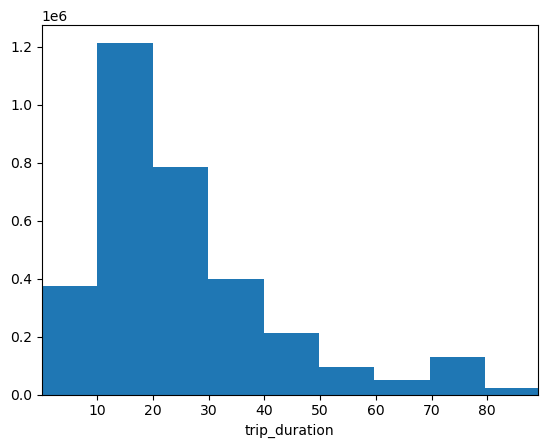

In [17]:
import matplotlib.pyplot as plt
plt.hist(y_train, bins=50)
plt.xlabel("trip_duration")
plt.xlim(np.min(y_train), np.percentile(y_train, 99))

# Modeling

In [4]:
# Baseline Model 1: Random Prediction
def random_predict(X):
    np.random.seed(42)
    return np.random.uniform(low=y.min(), high=y.max(), size=len(X))

# Baseline Model 2: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

# Expected Best Model: Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_train_pred = dt_model.predict(X_train)
dt_test_pred = dt_model.predict(X_test)

In [18]:
# lr_model algorithm
lr_model.coef_, lr_model.intercept_

(array([3.5091603], dtype=float32), np.float32(9.122213))

In [19]:
# dt_model algorithm
dt_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

# Evaluation

In [5]:
df_metrics = pd.DataFrame(columns=["Model", "Set_Category", "MAE", "MSE", "RMSE", "MAPE"])

def evaluate_model(name, dataset, y_true, y_pred):
    mae = MAE(y_true, y_pred)
    mse = MSE(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = MAPE(y_true, y_pred)

    df_metrics.loc[len(df_metrics)] = [name, dataset, mae, mse, rmse, mape]
    return df_metrics

# Evaluate Random Prediction
evaluate_model("Random Prediction", "Train", y_train, random_predict(X_train))
evaluate_model("Random Prediction", "Test", y_test, random_predict(X_test))
# Evaluate Linear Regression
evaluate_model("Linear Regression", "Train", y_train, lr_train_pred)
evaluate_model("Linear Regression", "Test", y_test, lr_test_pred)
# Evaluate Decision Tree Regressor
evaluate_model("Decision Tree Regressor", "Train", y_train, dt_train_pred)
evaluate_model("Decision Tree Regressor", "Test", y_test, dt_test_pred)

df_metrics

,Model,Set_Category,MAE,MSE,RMSE,MAPE
0,Random Prediction,Train,224.936315,70668.901451,265.836231,15.463675
1,Random Prediction,Test,225.028496,70692.786176,265.881150,15.410399
2,Linear Regression,Train,4.969563,82.948395,9.107601,0.470385
3,Linear Regression,Test,4.981627,86.119461,9.280057,0.481713
4,Decision Tree Regressor,Train,4.713450,67.941855,8.242685,0.472797
5,Decision Tree Regressor,Test,4.780491,77.992697,8.831347,0.497425


## Check Fit Status (Good, Underfit, or Overfit)

In [6]:
def check_fit_status(df, metric="MAE", threshold=0.1):
    """
    Classify models as Overfit / Underfit / Good fit.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns ["Model", "Set_Category", metric]
    metric : str, default="RMSE"
        Metric to compare between Train and Test
    threshold : float, default=0.2
        Relative tolerance (20% by default).
        If |Train - Test| > threshold * min(Train, Test), considered misfit.

    Returns
    -------
    pd.DataFrame
        Original df with an extra column 'Fit_Status'
    """
    result = df.copy()

    # Create a column for Fit_Status only for the Test rows
    result["Fit_Status"] = None

    # Work model by model
    for model in result["Model"].unique():
        train_row = result[(result.Model == model) & (result.Set_Category == "Train")].iloc[0]
        test_row = result[(result.Model == model) & (result.Set_Category == "Test")].iloc[0]

        train_err = train_row[metric]
        test_err = test_row[metric]

        gap = abs(test_err - train_err)
        rel_gap = gap / min(train_err, test_err)

        if rel_gap <= threshold:
            status = "Good fit"
        else:
            if test_err > train_err:
                status = "Overfit (high test error)"
            else:
                status = "Underfit (high train error)"  # rare but possible

        # Assign status to the test row
        idx = result[(result.Model == model) & (result.Set_Category == "Test")].index
        result.loc[idx, "Fit_Status"] = status

    return result

df_metrics = check_fit_status(df_metrics) 
df_metrics

,Model,Set_Category,MAE,MSE,RMSE,MAPE,Fit_Status
0,Random Prediction,Train,224.936315,70668.901451,265.836231,15.463675,None
1,Random Prediction,Test,225.028496,70692.786176,265.881150,15.410399,Good fit
2,Linear Regression,Train,4.969563,82.948395,9.107601,0.470385,None
3,Linear Regression,Test,4.981627,86.119461,9.280057,0.481713,Good fit
4,Decision Tree Regressor,Train,4.713450,67.941855,8.242685,0.472797,None
5,Decision Tree Regressor,Test,4.780491,77.992697,8.831347,0.497425,Good fit


# Use Model

In [7]:
# Manual prediction using Linear Regression coefficients
a = lr_model.coef_[0]
b = lr_model.intercept_

f_x = lambda x: a*x + b
print(f"f(x) = {a} * x + {b}")
print(f"f(`trip_distance`) = {a} * `trip_distance` + {b}", "\n")

print(f"f(10) = $ {f_x(10).round(2)}")
print(f"f(20) = $ {f_x(20).round(2)}")
print(f"f(30) = $ {f_x(30).round(2)}")

f(x) = 3.509160280227661 * x + 9.122213363647461
f(`trip_distance`) = 3.509160280227661 * `trip_distance` + 9.122213363647461 

f(10) = $ 44.209999084472656
f(20) = $ 79.30999755859375
f(30) = $ 114.4000015258789


In [8]:
# Prediction using Linear Regression model
lr_model.predict([[10]]).round(2), lr_model.predict([[20]]).round(2), lr_model.predict([[30]]).round(2)

(array([44.21]), array([79.31]), array([114.4]))

In [9]:
# Prediction using Decisiont Tree Regressor
dt_model.predict([[10]]).round(2), dt_model.predict([[20]]).round(2), dt_model.predict([[30]]).round(2)

(array([43.27]), array([72.55]), array([106.4]))

In [11]:
# Export Model
joblib.dump(lr_model, "./model/lr.joblib")
joblib.dump(dt_model, "./model/dt.joblib")


['./model/dt.joblib']